# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [19]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd


In [5]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [6]:
spaceship = spaceship.dropna()

In [7]:
spaceship['Cabin'] = spaceship['Cabin'].str[0]

In [8]:
spaceship = spaceship.drop(columns=['PassengerId', 'Name'])

In [9]:
#- For non-numerical columns, do dummies.
dummies_spaceship = pd.get_dummies(spaceship, drop_first=True)
dummies_spaceship = dummies_spaceship.astype(int)
dummies_spaceship.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True
0,39,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,24,109,9,25,549,44,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,58,43,3576,0,6715,49,0,1,0,0,0,0,0,0,0,0,0,0,1,1
3,33,0,1283,371,3329,193,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,16,303,70,151,565,2,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [10]:
features = dummies_spaceship.drop('Transported', axis=1)
target = dummies_spaceship['Transported']

- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




In [22]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train model and return key metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    return metrics

In [23]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm="SAMME")}

In [24]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = metrics

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by="ROC-AUC", ascending=False)
print (results_df)


Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training Decision Tree...
Training AdaBoost...
                     Accuracy  Precision    Recall        F1   ROC-AUC
Gradient Boosting    0.807110   0.782787  0.856502  0.817987  0.889662
Logistic Regression  0.791982   0.787172  0.807175  0.797048  0.881636
Random Forest        0.808623   0.820988  0.795217  0.807897  0.877973
AdaBoost             0.776853   0.826923  0.707025  0.762288  0.862816
Decision Tree        0.757186   0.752174  0.775785  0.763797  0.774955


- Evaluate your model

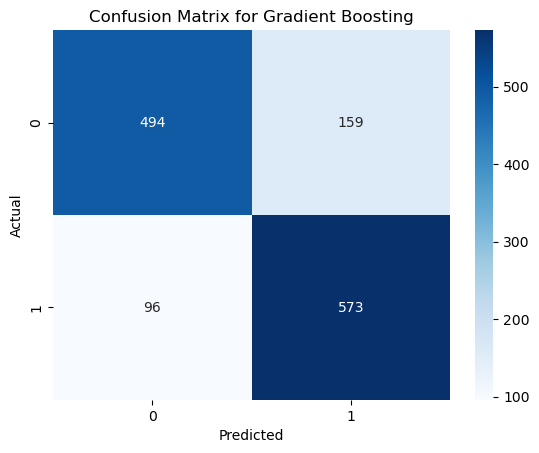

In [25]:
# evaluate best model confusion matrix
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

In [27]:
#define hyperparameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}


- Run Grid Search

In [28]:
# Grid Search with Cross-Validation
gbc = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, 
                           scoring='roc_auc', cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_gbc = grid_search.best_estimator_
metrics = evaluate_model(best_gbc, X_train, y_train, X_test, y_test)

print("Metrics after Hyperparameter Tuning:", metrics)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Metrics after Hyperparameter Tuning: {'Accuracy': 0.8071104387291982, 'Precision': 0.7827868852459017, 'Recall': 0.8565022421524664, 'F1': 0.8179871520342612, 'ROC-AUC': 0.8896618344217901}


- Evaluate your model

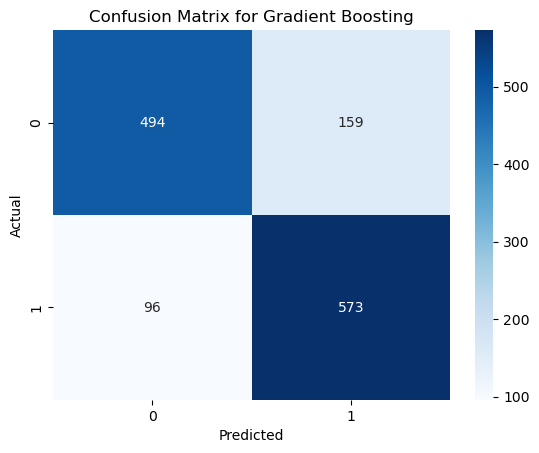

In [30]:
# evaluate best model confusion matrix
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
